In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

### Constantes

#### Hodgkin-Huxley

In [2]:
#Conductividades: se expresan en [mS/cm^2], pero tras normalizar la ecuación quedan adimensionales
g_Na = 120
g_K = 36 
g_Cl = 0.3


#Voltajes de inversion [mV]
V_Na = 50
V_K = -77
V_Cl = -54.4

#Capacitancia (C): se expresa en [uF/cm^2], pero tras normalizar la ecuación queda en [ms] y vale 1, por lo que ni se incluye en la ecuación

#Corriente externa (la misma para ambas neuronas)
I_ext = 20 #[uA/cm^2]

#### Acoplamiento

In [3]:
#V_syn = 0 #[mV] Caso excitatorio
V_syn = -80 #[mV] Caso inhibitorio
tau_s = 3 #[ms]

K = 41 #Cantidad de iteraciones
g_syn = np.linspace(0.1, 10.1, K) #[mS/cm^2]

### Funciones

In [4]:
#Funciones auxiliares

def inf_x(a, b):
    '''
    Devuelve el valor para t = inf en función de los coeficientes a y b (para los coeficientes m, h y n)
    '''
    inf = a/(a+b)
    return inf

def tau_x(a, b):
    '''
    Devuelve el parámetro tau en función de los coeficientes a y b (para los coeficientes m, h y n)
    '''
    tau = 1/(a+b)
    return tau

#Ecuaciones diferenciales del modelo
def derivada(t, u, g_s):
    '''
    Recibe los parámetro I (corriente externa) y v_pre (potencial de la otra Neurona) y los valores actuales del vector de variables u = (v, m, h, n)
    y devuelve la derivada de cada una de dichas variables
    '''
#Variables

    #Neurona 1
    v1 = u[0]
    s1 = u[1]
    m1 = u[2]
    h1 = u[3]
    n1 = u[4]

    #Neurona 2
    v2 = u[5]
    s2 = u[6]
    m2 = u[7]
    h2 = u[8]
    n2 = u[9]

#Corrientes sinápticas (parámetros para el cálculo de dv)

    #Proveniente de la neurona 1 (hacia la neurona 2)
    I_syn12 = -g_s*s1*(v2-V_syn)

    #Proveniente de la neurona 2 (hacia la neurona 1)
    I_syn21 = -g_s*s2*(v1-V_syn)


#Potenciales

    #Neurona 1
    dv1 = I_ext - g_Na*(m1**3)*h1*(v1-V_Na) - g_K*(n1**4)*(v1-V_K) - g_Cl*(v1-V_Cl) + I_syn21

    #Neurona 2
    dv2 = I_ext - g_Na*(m2**3)*h2*(v2-V_Na) - g_K*(n2**4)*(v2-V_K) - g_Cl*(v2-V_Cl) + I_syn12


#Coeficiente s de las corrientes sinápticas (acoplamiento)

    #Neurona 1
    inf_s1 = 0.5*(1+np.tanh(v1/5)) #V_pre (enunciado) es el potencial en la neurona que genera la corriente
    ds1 = (inf_s1 - s1)/tau_s

    #Neurona 2
    inf_s2 = 0.5*(1+np.tanh(v2/5)) #V_pre (enunciado) es el potencial en la neurona que genera la corriente
    ds2 = (inf_s2 - s2)/tau_s


#Coeficientes de los canales iónicos(Hodgkin-Huxley)

    #Neurona 1
        #m
    a_m1 = 0.1*(v1+40)/(1-np.exp((-v1-40)/10))
    b_m1 = 4*np.exp((-v1-65)/18)
    inf_m1 = inf_x(a_m1, b_m1)
    tau_m1 = tau_x(a_m1, b_m1)
    dm1 = (inf_m1 - m1)/tau_m1

        #h
    a_h1 = 0.07*np.exp((-v1-65)/20)
    b_h1 = 1/(1+np.exp((-v1-35)/10))
    inf_h1 = inf_x(a_h1, b_h1)
    tau_h1 = tau_x(a_h1, b_h1)
    dh1 = (inf_h1 - h1)/tau_h1

        #n
    a_n1 = 0.01*(v1+55)/(1-np.exp((-v1-55)/10))
    b_n1 = 0.125*np.exp((-v1-65)/80)
    inf_n1 = inf_x(a_n1, b_n1)
    tau_n1 = tau_x(a_n1, b_n1)
    dn1 = (inf_n1 - n1)/tau_n1

    #Neurona 2
        #m
    a_m2 = 0.1*(v2+40)/(1-np.exp((-v2-40)/10))
    b_m2 = 4*np.exp((-v2-65)/18)
    inf_m2 = inf_x(a_m2, b_m2)
    tau_m2 = tau_x(a_m2, b_m2)
    dm2 = (inf_m2 - m2)/tau_m2

        #h
    a_h2 = 0.07*np.exp((-v2-65)/20)
    b_h2 = 1/(1+np.exp((-v2-35)/10))
    inf_h2 = inf_x(a_h2, b_h2)
    tau_h2 = tau_x(a_h2, b_h2)
    dh2 = (inf_h2 - h2)/tau_h2

        #n
    a_n2 = 0.01*(v2+55)/(1-np.exp((-v2-55)/10))
    b_n2 = 0.125*np.exp((-v2-65)/80)
    inf_n2 = inf_x(a_n2, b_n2)
    tau_n2 = tau_x(a_n2, b_n2)
    dn2 = (inf_n2 - n2)/tau_n2


#Derivadas
    du = [dv1, ds1, dm1, dh1, dn1, dv2, ds2, dm2, dh2, dn2]

    return du

### Valores iniciales para cada neurona

In [5]:
#Neurona 1
v01 = -30 #[mV]

s01 = 0.5*(1+np.tanh(v01/5))

a_m01 = 0.1*(v01+40)/(1-np.exp((-v01-40)/10))
b_m01 = 4*np.exp((-v01-65)/18)
m01 = inf_x(a_m01, b_m01)

a_h01 = 0.07*np.exp((-v01-65)/20)
b_h01 = 1/(1+np.exp((-v01-35)/10))
h01 = inf_x(a_h01, b_h01)

a_n01 = 0.01*(v01+55)/(1-np.exp((-v01-55)/10))
b_n01 = 0.125*np.exp((-v01-65)/80)
n01 = inf_x(a_n01, b_n01)


#Neurona 2
v02 = -80 #[mV]

s02 = 0.5*(1+np.tanh(v02/5))

a_m02 = 0.1*(v01+40)/(1-np.exp((-v02-40)/10))
b_m02 = 4*np.exp((-v02-65)/18)
m02 = inf_x(a_m02, b_m02)

a_h02 = 0.07*np.exp((-v02-65)/20)
b_h02 = 1/(1+np.exp((-v02-35)/10))
h02 = inf_x(a_h02, b_h02)

a_n02 = 0.01*(v02+55)/(1-np.exp((-v02-55)/10))
b_n02 = 0.125*np.exp((-v02-65)/80)
n02 = inf_x(a_n02, b_n02)


#Vector de valores iniciales para la solución numérica
semilla = [v01, s01, m01, h01, n01, v02, s02, m02, h02, n02]

#### Tiempos de la simulación

In [6]:
t_ini = 0   #[ms]
# t_fin lo defino en función de g_syn

#Tasa de disparo de cada neurona y fase entre sus spikes
f1 = np.zeros(K)
f2 = np.zeros(K)
t_est = np.zeros(K)

#### Solución numérica
Para cambiar del caso excitatorio al inhibitorio o viceversa, hay que comentar/descomentar el valor de la variable h, el if que reacomoda la fase entre potenciales y el valor de V_syn (celda "Acoplamiento")

C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:94: RuntimeWarning: overflow encountered in exp
  a_m2 = 0.1*(v2+40)/(1-np.exp((-v2-40)/10))
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:95: RuntimeWarning: overflow encountered in exp
  b_m2 = 4*np.exp((-v2-65)/18)
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:98: RuntimeWarning: divide by zero encountered in scalar divide
  dm2 = (inf_m2 - m2)/tau_m2
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:101: RuntimeWarning: overflow encountered in exp
  a_h2 = 0.07*np.exp((-v2-65)/20)
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:102: RuntimeWarning: overflow encountered in exp
  b_h2 = 1/(1+np.exp((-v2-35)/10))
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:7: RuntimeWarning: invalid value encountered in scalar divide
  inf = a/(a+b)
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:108: RuntimeWarning: overflow encountered in exp
  a_n2 

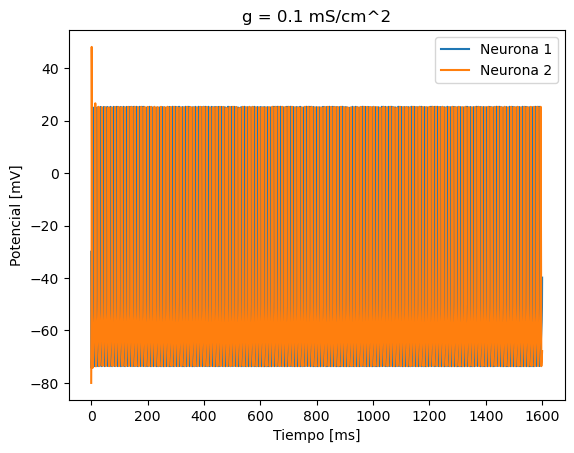

C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:72: RuntimeWarning: overflow encountered in exp
  a_m1 = 0.1*(v1+40)/(1-np.exp((-v1-40)/10))
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:73: RuntimeWarning: overflow encountered in exp
  b_m1 = 4*np.exp((-v1-65)/18)
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  dm1 = (inf_m1 - m1)/tau_m1
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:79: RuntimeWarning: overflow encountered in exp
  a_h1 = 0.07*np.exp((-v1-65)/20)
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:80: RuntimeWarning: overflow encountered in exp
  b_h1 = 1/(1+np.exp((-v1-35)/10))
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:86: RuntimeWarning: overflow encountered in exp
  a_n1 = 0.01*(v1+55)/(1-np.exp((-v1-55)/10))
C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:87: RuntimeWarning: overflow encountered i

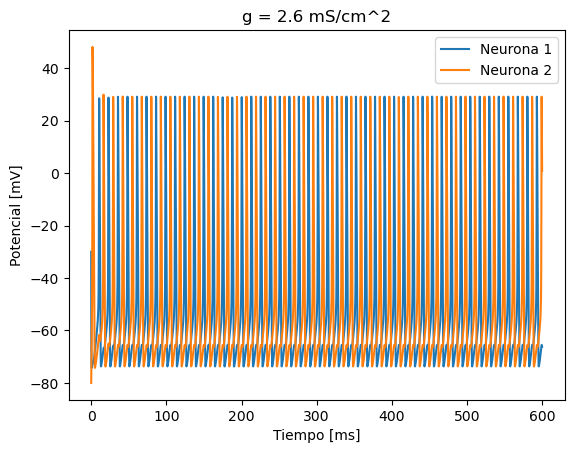

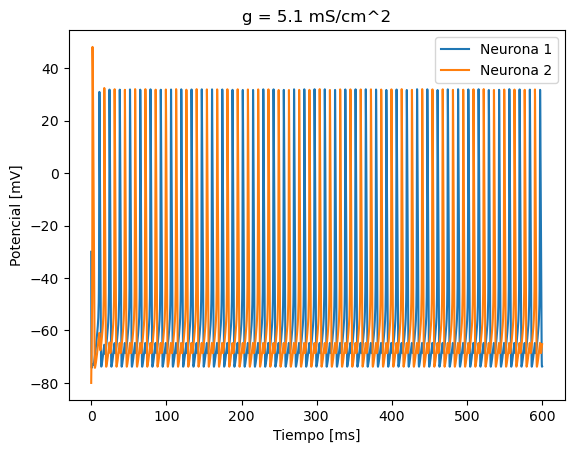

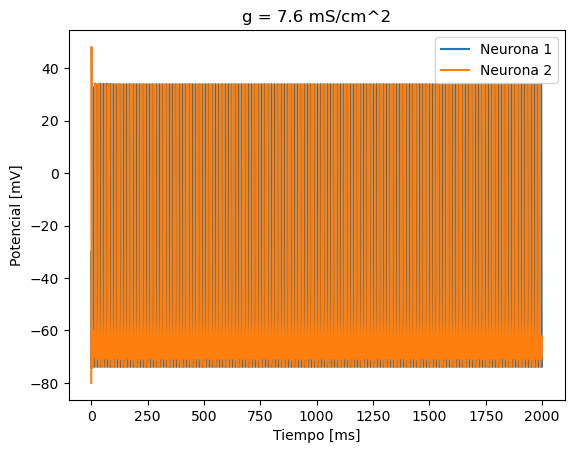

C:\Users\gatoa\AppData\Local\Temp\ipykernel_9872\717528797.py:51: RuntimeWarning: overflow encountered in scalar multiply
  dv1 = I_ext - g_Na*(m1**3)*h1*(v1-V_Na) - g_K*(n1**4)*(v1-V_K) - g_Cl*(v1-V_Cl) + I_syn21


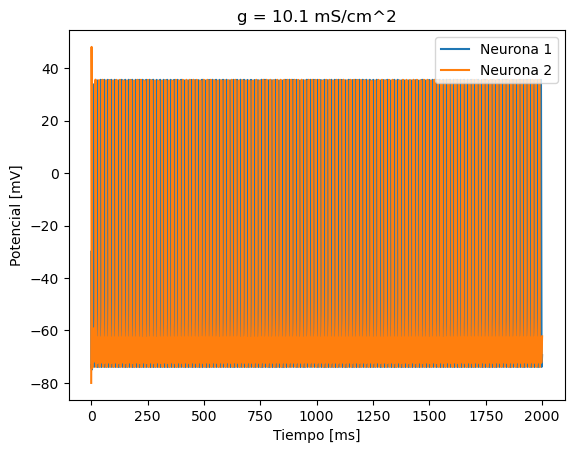

In [7]:
for i in range(K):
    if(i < 2):  #A menor g, estabilización más lenta --> debo ejecutar simulaciones más largas
        t_fin = 1600
    elif(i < (K+1)/2): 
        t_fin = 600
    else:
        t_fin = 2000 #A mayor g, menor tasa de disparo --> necesito más tiempo para ver más picos

    result = solve_ivp(lambda t, u: derivada(t, u, g_syn[i]), [t_ini, t_fin], semilla)

    #Resultados de la solución numérica
    t = result.t
    v1 = result.y[0]
    s1 = result.y[1]
    m1 = result.y[2]
    h1 = result.y[3]
    n1 = result.y[4]
    v2 = result.y[5]
    s2 = result.y[6]
    m2 = result.y[7]
    h2 = result.y[8]
    n2 = result.y[9]


    #Cada 10 simulaciones, grafico el potencial en función del tiempo para ambas neuronas
    if(i%10 == 0):
        plt.plot(t, v1, label = "Neurona 1")
        plt.plot(t, v2, label = "Neurona 2")
        plt.title("g = " + str(g_syn[i]) + " mS/cm^2")
        plt.xlabel("Tiempo [ms]")
        plt.ylabel("Potencial [mV]")
        plt.legend()
        plt.show()


    max1 = find_peaks(v1, height=0)[0] #Indice de los máximos obtenidos (neurona 1)
    max2 = find_peaks(v2, height=0)[0] #Indice de los máximos obtenidos (neurona 2)

    if(len(max1) < 2):
        f1[i] = 0
        continue
    if(len(max2) < 2):
        f2[i] = 0
        continue

    #Tasa de disparo (neurona 1)
    T1 = 0
    for k in range(len(max1) - 1):
        T1 += t[max1[k+1]] - t[max1[k]]
    
    T1 = T1/(len(max1)-1) #[ms]

    f1[i] = 1000/T1 #[Hz]

    #Tasa de disparo (neurona 2)
    T2 = 0
    for k in range(len(max2) - 1):
        T2 += t[max2[k+1]] - t[max2[k]]
    
    T2 = T2/(len(max2)-1) #[ms]

    f2[i] = 1000/T2 #[Hz]

    #Fase entre los disparos
    fase = np.zeros(len(max1))

    #h = 0 #Fase de estabilización (caso excitatorio)
    h = 180 #Fase de estabilización (caso inhibitorio)

    no_est = True #bandera

    #Recorro los máximos de potencial y me fijo el tiempo en el que ocurren --> calculo la fase entre ambas neuronas
    for k in range(len(max1)):
        fase[k] = (t[max1[k]] - t[max2[k]])*360/np.mean([T1, T2])
        
        # Caso excitatorio. 360 = 0
        # if(fase[k] > 180):
        #     fase[k] = fase[k] - 360
        
        #Caso inhibitorio. -180 = 180
        if(fase[k] < 0):
            fase[k] = fase[k] + 360

        if(k < len(max1)and k >= 3 and no_est):
            #Si en 4 máximos seguidos la fase difiere menos de 5 grados del valor final, lo considero estable
            if((abs(fase[k]-h) < 5) and (abs(fase[k-1]-h) < 5) and (abs(fase[k-2]-h) < 5)  and (abs(fase[k-3]-h) < 5)):
                no_est = False
                t_est[i] = np.mean(t[max1[k-4:k-2]])      

    

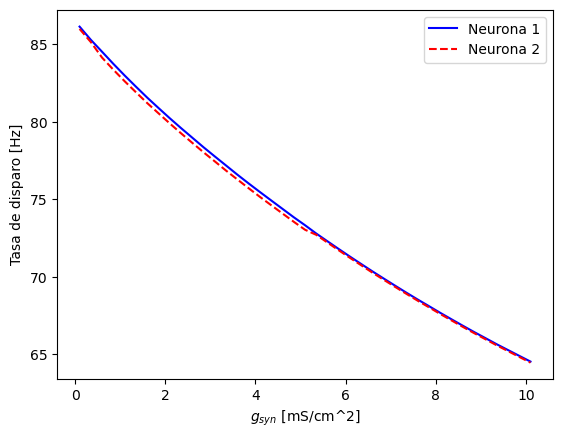

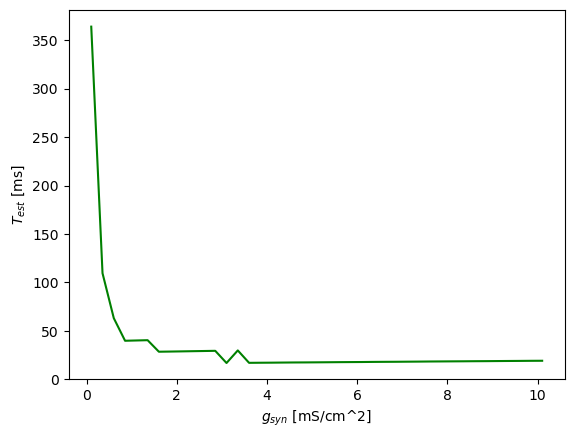

In [8]:
plt.plot(g_syn, f1, color = 'b', label = "Neurona 1")
plt.plot(g_syn, f2, ls = '--', color = 'r', label = "Neurona 2")
plt.xlabel("$g_{syn}$ [mS/cm^2]")
plt.ylabel("Tasa de disparo [Hz]")
plt.legend()
plt.show()

plt.plot(g_syn, t_est, c = 'g')
plt.xlabel("$g_{syn}$ [mS/cm^2]")
plt.ylabel("$T_{est}$ [ms]")
#plt.xlim(0,4)
plt.ylim(0)
plt.show()